# DiploDatos Kaggle Competition

Presentamos un código creado como ejemplo de base para la competición.

Deben:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presenta en este ejemplo.**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.

El análisis exploratorio y el preprocesamiento de los datos queda a libertad de cada grupo y no deben quedarse con este simple ejemplo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from xgboost import XGBClassifier, XGBRFClassifier

## Leer el dataset

### Train

Cargamos los datos de entrenamiento que vamos a utilizar para generar nuestro modelo.

In [2]:
df = pd.read_csv('data/diabetes_prediction_dataset_train-labeled.csv')
print(df.shape)
print(df.describe())

(95000, 10)
             patient           age  hypertension  heart_disease           bmi  \
count   95000.000000  95000.000000  95000.000000   95000.000000  95000.000000   
mean    50016.501389     41.935269      0.075074       0.039463     27.320879   
std     28868.357071     22.514788      0.263512       0.194695      6.626335   
min         1.000000      0.080000      0.000000       0.000000     10.010000   
25%     25021.750000     24.000000      0.000000       0.000000     23.650000   
50%     50024.000000     43.000000      0.000000       0.000000     27.320000   
75%     75024.250000     60.000000      0.000000       0.000000     29.580000   
max    100000.000000     80.000000      1.000000       1.000000     95.690000   

        HbA1c_level  blood_glucose_level      diabetes  
count  95000.000000         95000.000000  95000.000000  
mean       5.527659           138.070537      0.085074  
std        1.070261            40.739962      0.278993  
min        3.500000           

In [3]:
df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


La columna ***`diabetes`*** es la columna que debemos predecir. En el dataset de Test esta columna tiene valores nulos.

## Analisis de los datos

#### Vemos si hay desbalance

<AxesSubplot:>

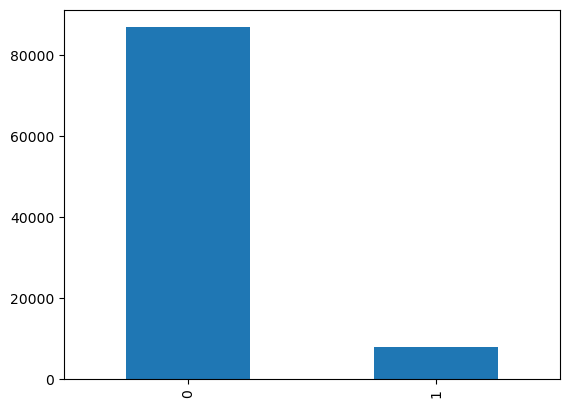

In [5]:
df.diabetes.value_counts().plot(kind='bar')

**¡Clases desbalanceadas!** y que sucede si analizamos genero y edad?

##### Vemos si hay nulos

In [6]:
df.isnull().sum()

patient                0
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

No hay nulos en el dataset por lo que no es necesario imputarlos

#### Separamos a las columnas en numéricas y categóricas

In [7]:
cat_cols = ['gender', 'smoking_history']
num_cols = [x for x in df.columns if x not in cat_cols and x not in ['patient', 'diabetes']]
# En las columnas numéricas quitamos la columna "patient" que contiene el id de los pacientes y "diabetes" que es la variable target

#### Análisis de las variables numéricas

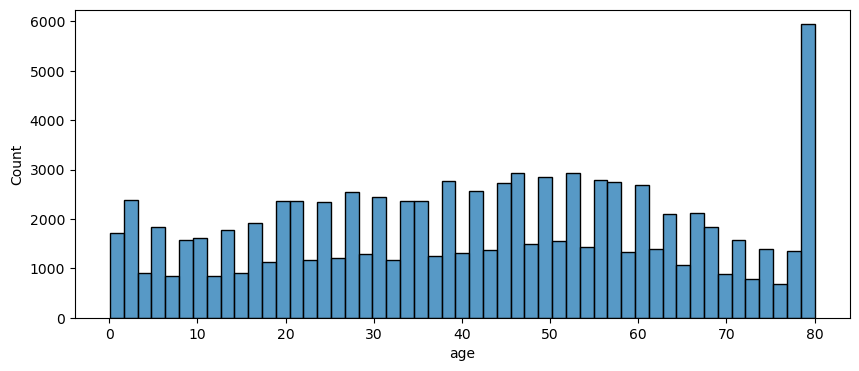

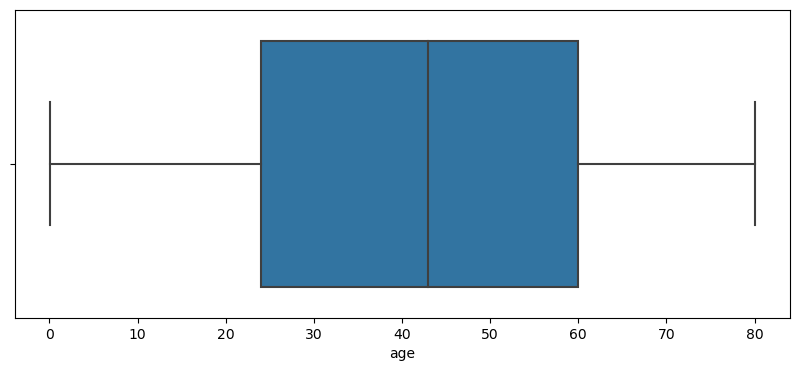

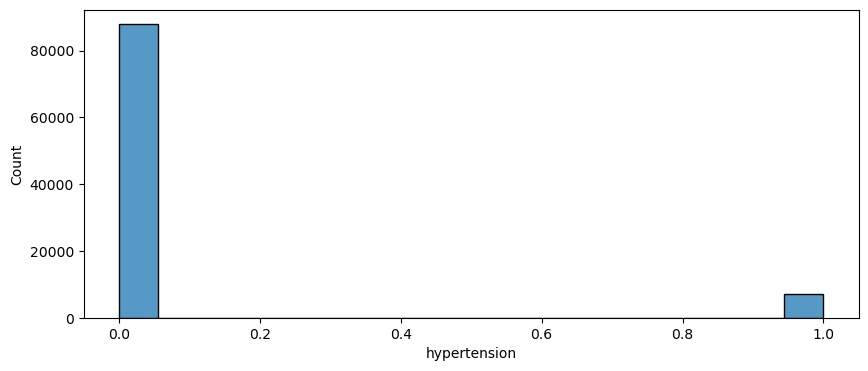

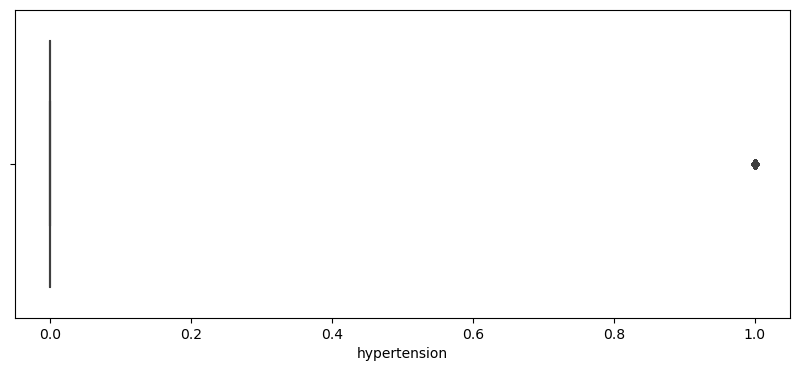

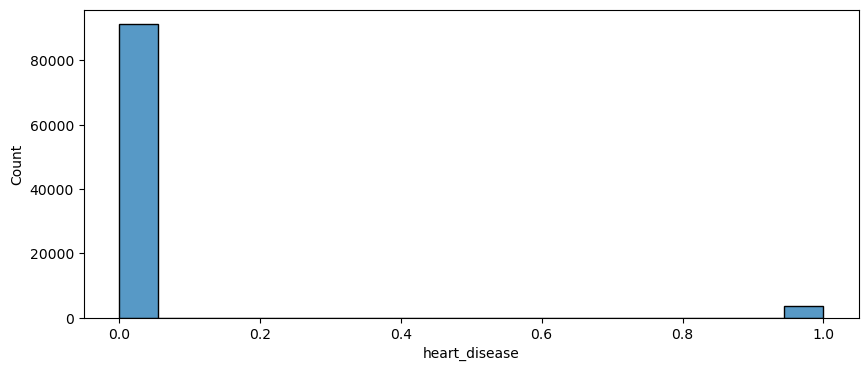

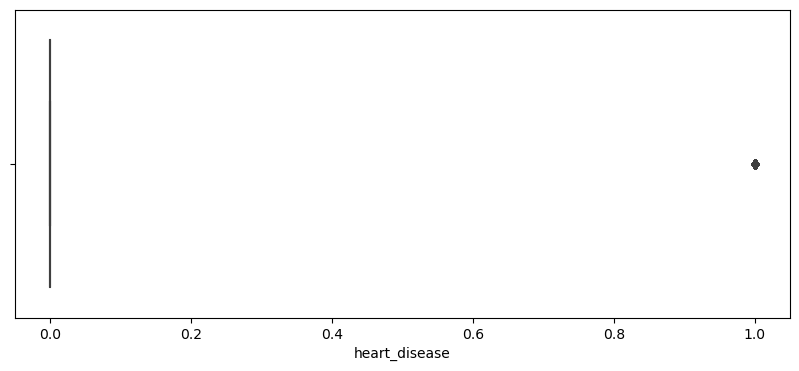

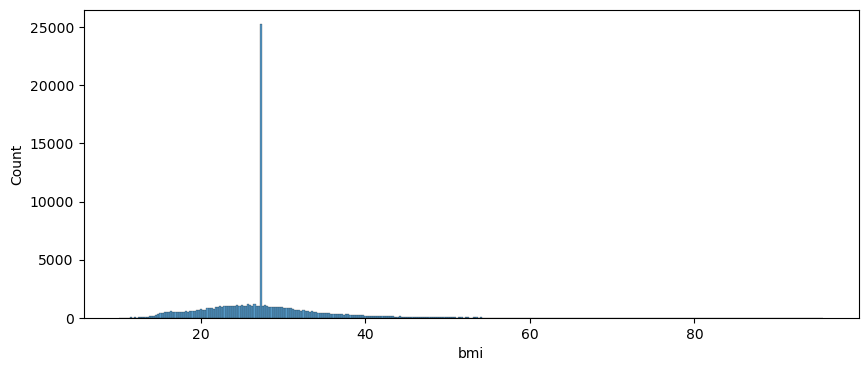

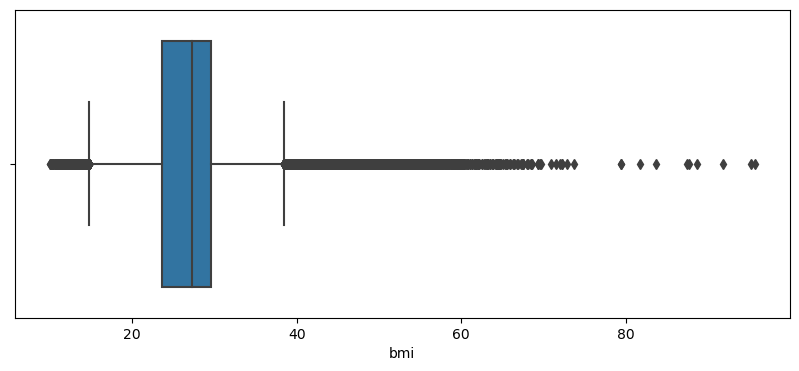

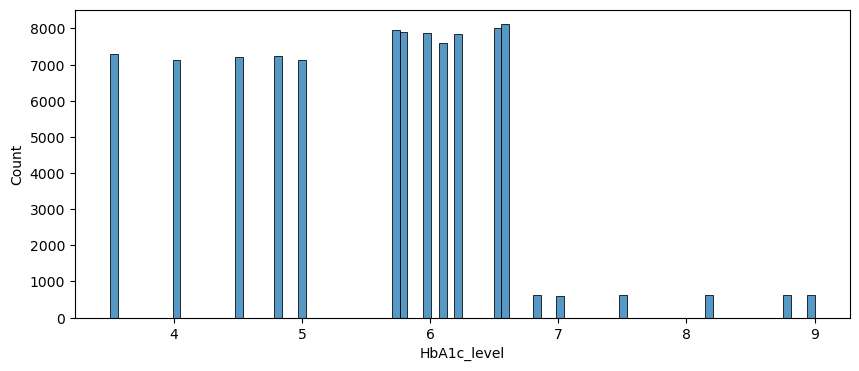

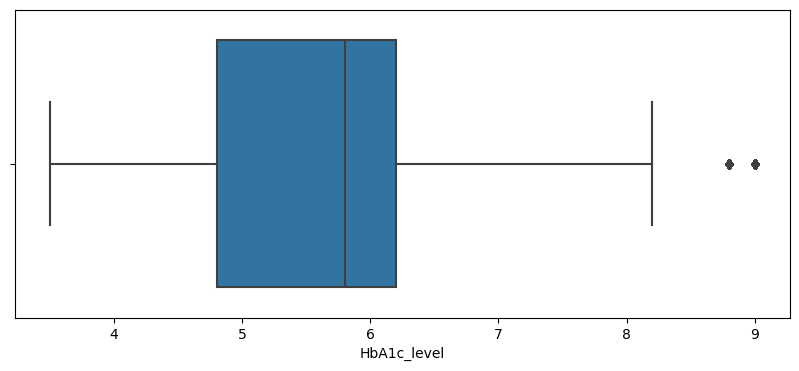

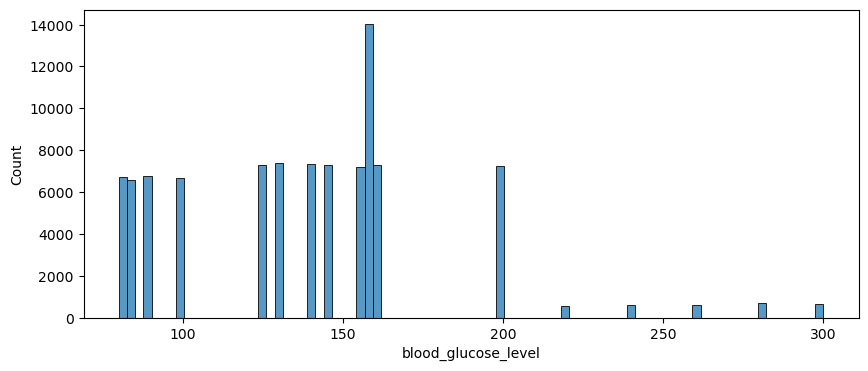

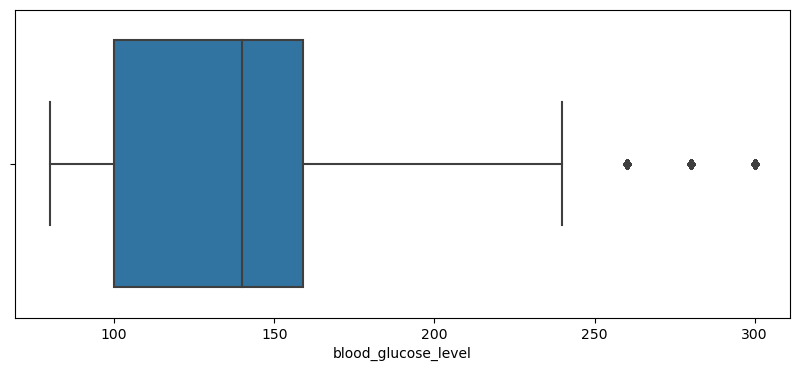

In [8]:
for col in num_cols:
    plt.figure(figsize=(10,4))
#     if col=='bmi':
#         plt.xscale('log')
#         plt.yscale('log')
    sns.histplot(data=df, x=col)
    plt.show()
    plt.figure(figsize=(10,4))
    sns.boxplot(data=df, x=col)
    plt.show()

En ningún caso se observan outliers significativos, por lo que se decide no realizar ninguna eliminación ni imputación

#### Análisis de las variables categóricas

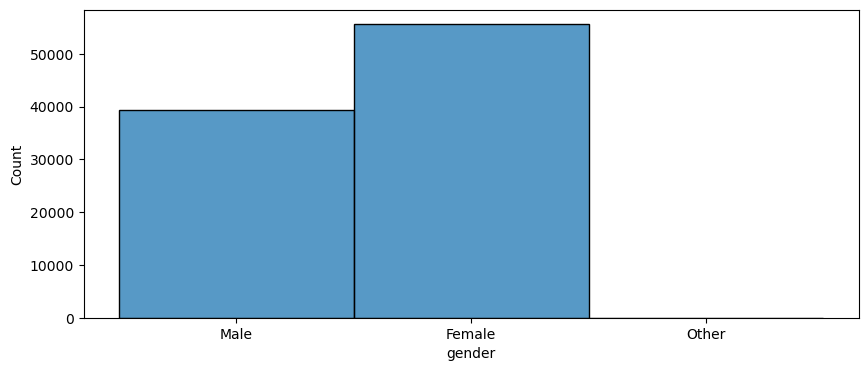

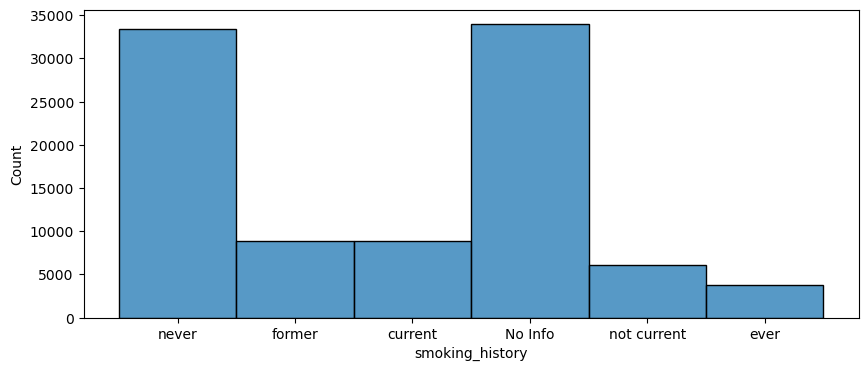

In [9]:
for col in cat_cols:
    plt.figure(figsize=(10,4))
    sns.histplot(data=df, x=col)
    plt.show()

Se puede observar que cada variable categórica posee pocas categorías. Además se observa que son variables nominales.

#### Preprocesamiento

Necesitamos transformar las variables que son categoricas a númericas, como por ejemplo **gender** y **smoking_history**

In [10]:
X = df.drop(columns=['patient', 'diabetes'])
y = df['diabetes']
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 8)

In [11]:
# Armo el pipeline
ohe = OneHotEncoder(drop='first')
scaler = StandardScaler()
pipeline = ColumnTransformer(
    [("OHE"  , ohe  , cat_cols),
     ("StandardScaler", scaler, num_cols)
    ]
  )
pipeline

ColumnTransformer(transformers=[('OHE', OneHotEncoder(drop='first'),
                                 ['gender', 'smoking_history']),
                                ('StandardScaler', StandardScaler(),
                                 ['age', 'hypertension', 'heart_disease', 'bmi',
                                  'HbA1c_level', 'blood_glucose_level'])])

In [12]:
# Fiteo el pipeline
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [13]:
# Guardo el pipeline
import joblib

pipeline = joblib.dump(pipeline, 'pipeline.pkl')

In [14]:
name = 'XGBClassifier'
xgb = XGBClassifier()
xgb.fit(x_train_transformed, y_train)
train_predictions = xgb.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

train_predictions = xgb.predict(x_test_transformed)
accuracy = accuracy_score(y_test, train_predictions)
print(f"Accuracy test {name}: %.2f%%" % (accuracy * 100.0))

Accuracy train XGBClassifier: 97.60%
Accuracy test XGBClassifier: 97.29%


### Algún tipo de ajuste de hiperparámetros de los modelos elegidos

In [15]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

grid = GridSearchCV(XGBClassifier(), params)
grid.fit(x_train_transformed,y_train)
grid.best_params_

KeyboardInterrupt: 

In [ ]:
xgb = XGBClassifier(**grid.best_params_).fit(x_train_transformed, y_train)

train_predictions = xgb.predict(x_train_transformed)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train XGBoost: %.2f%%" % (accuracy * 100.0))

test_predictions = xgb.predict(x_test_transformed)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test XGBoost: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,xgb.predict(x_test_transformed)))

In [ ]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=10)

x_train2 = np.array(x_train_transformed)
y_train2 = np.array(y_train)


xgb = XGBClassifier(**grid.best_params_)
name = 'XGBClassifier'
print(xgb)
avg_accuracy = 0
for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
    xi, yi = x_train2[train_idx], y_train2[train_idx]
    x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
    xgb = xgb.fit(xi, yi)

    test_predictions = xgb.predict(x_valid)
    accuracy = accuracy_score(y_valid, test_predictions)
    avg_accuracy +=accuracy
    print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

avg_accuracy /= FOLDS
print(f'Avg. accuracy = {avg_accuracy * 100}')

## Generar la salida para entregar

In [ ]:
test_df = pd.read_csv('diabetes_prediction_dataset_test.csv')


In [ ]:
test_df

Para poder evaluar nuestra predicción los datos de prueba deben tener exactamente el mismo tratamiento que los datos de entrenamiento

In [ ]:
Y_test = test_df.diabetes
X_test = test_df.drop(columns=['patient','diabetes'])
PatientId_test = test_df['patient']


In [ ]:
pipeline = joblib.load('pipeline.pkl')

In [ ]:
X_test_transformed = pipeline.transform(X_test)

In [ ]:
# Para obtener el nombre de las columnas creadas a partir del OneHotEncoder es necesario acceder al mismo de esta manera:
pipeline.transformers_[0][1]

In [ ]:
# Con el método get_features_names_out se puede obtener el nombre de las columnas creadas
pipeline.transformers_[0][1].get_feature_names_out()

In [ ]:
cols = pipeline.transformers_[0][1].get_feature_names_out().tolist() + num_cols
X_test_transformed = pd.DataFrame(X_test_transformed, columns=cols)

Generamos la salida

In [ ]:
test_id = PatientId_test
test_pred = np.int64(xgb.predict(X_test_transformed))

Con el resultado predicho tenemos que generar el archivo `.csv` para subir a la competencia de kaggle:

In [ ]:
submission = pd.DataFrame(list(zip(test_id, test_pred)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission.csv", header=True, index=False)